<h1>Preprocessing</h1>

In [1]:
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram,linkage

from sklearn.cluster import AgglomerativeClustering #AGNES
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from mlxtend.evaluate import paired_ttest_5x2cv

import matplotlib.pyplot as plt

import warnings

import seaborn as sn

import warnings

from collections import Counter
from sklearn import svm
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn.metrics import silhouette_samples,silhouette_score,adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering #AGNES
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings('ignore')

#Reading data
df2014=pd.read_csv("../2014_Financial_Data.csv")
df2015=pd.read_csv("../2015_Financial_Data.csv")
df2016=pd.read_csv("../2016_Financial_Data.csv")
df2017=pd.read_csv("../2017_Financial_Data.csv")
df2018=pd.read_csv("../2018_Financial_Data.csv")

#Changing column name for price variation into same name
df2014.rename(columns={"2015 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2015.rename(columns={"2016 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2016.rename(columns={"2017 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2017.rename(columns={"2018 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2018.rename(columns={"2019 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)

#Adding year attribute for each csv file
df2014['Year']=2014
df2015['Year']=2015
df2016['Year']=2016
df2017['Year']=2017
df2018['Year']=2018

data = pd.concat([df2014 ,df2015, df2016, df2017, df2018])
data.rename(columns={'Unnamed: 0':'Stock'}, inplace=True)

print(len(df2018))
data.info()
data.head()

4392
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 4391
Columns: 226 entries, Stock to Year
dtypes: float64(222), int64(2), object(2)
memory usage: 38.2+ MB


,Stock,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR NEXT YEAR,Class,Year
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0,2014
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0,2014
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1,2014
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1,2014
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1,2014


In [2]:
X=data
y=data["Class"]

X=X.drop("Stock",axis=1)
X=X.drop("PRICE VAR NEXT YEAR",axis=1)
X=X.drop("Class",axis=1)
X=X.drop("Year",axis=1)

<h3>Dropping attributes which frequently contain missing values, Dimensionality Reduction</h3>

In [3]:
attributeNames=X.columns.tolist()
missingPercentage = X.isnull().sum() * 100 / len(X) # missing val % for each column
thresholdedAttribute=missingPercentage.where(missingPercentage>=33)
thresholdedAttribute=[attributeNames[a] for a in range(len(thresholdedAttribute)) if str(thresholdedAttribute[a]) != "nan"]
print(thresholdedAttribute,len(thresholdedAttribute))

['priceEarningsToGrowthRatio', 'ebtperEBIT', 'niperEBT', 'effectiveTaxRate', 'nIperEBT', 'eBTperEBIT', 'operatingCycle', 'cashConversionCycle', 'shortTermCoverageRatios', 'dividendPayoutRatio', 'Net Debt to EBITDA', '10Y Revenue Growth (per Share)', '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)', '10Y Shareholders Equity Growth (per Share)', '10Y Dividend per Share Growth (per Share)'] 16


In [4]:
#drop the columns that has more than 33% missing values
print(X.shape)
X=X.drop(thresholdedAttribute,axis=1)
print(X.shape)
attributeNames=X.columns.tolist()
missingPercentage = X.isnull().sum() * 100 / len(X) # missing val % for each column

(22077, 222)
(22077, 206)


In [5]:
# Replace nan-values with mean value of column, considering each sector individually.
X = X.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))

**Reducing Dimensions to 2 with PCA**

In [6]:
# Define the scaler 
scaler = StandardScaler().fit(X)
# Scale the X
X_scaled = scaler.transform(X)
X_reduced = PCA(2).fit_transform(X_scaled) #reducing data into 2 dimension

<h3>Clustering</h3>

**Choosing number of clusters for K-Means with Elbow Method**

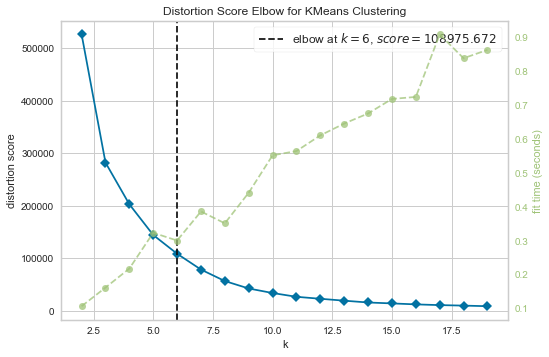

In [7]:
def Elbow(X):
    # Instantiate the clustering model and visualizer
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,20))
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure
    
Elbow(X_reduced)

In [8]:
def dfInsertRow(df,row):
    row_series = pd.Series(row, index = df.columns)
    df = df.append(row_series, ignore_index=True)
    return df
    
def Clustering(clusteringMethod,X, labels_true, clusteringMethodName,explode): #Clustering
    cls = clusteringMethod.fit(X)
    noClusters = len(np.unique(cls.labels_))
    labels=cls.labels_
    
    unique_elements, counts_elements = np.unique(labels, return_counts=True)
    #explode = [0.2, 0,  0.2, 0.4, 0.6, 0.8]
    labels_plt = unique_elements
    sizes = counts_elements
    # Plot
    #plt.figure(figsize=(10,10))
    plt.pie(sizes,labels=labels_plt, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()
    
    
    averag=counts_elements.mean()
    stdDev=counts_elements.std()
    clusters=dict(sorted(Counter(labels).items()))
    clusters['avg']=counts_elements.mean()
    try:
        SSE=cls.inertia_
    except:
        SSE="---"
    silhoutteVal=metrics.silhouette_score(X, labels)
    RI=metrics.adjusted_rand_score(labels_true, labels)
    NMI=metrics.normalized_mutual_info_score(labels_true, labels)
    
    return [clusteringMethodName, noClusters, clusters, stdDev, SSE, NMI, silhoutteVal, RI]

dfEvaluation  = pd.DataFrame(columns = ["Experiment", "# of Clusters", "Average Number of Instances in Clusters", "Std. Dev.", "SSE","NMI","Silhoutte Value","Adjusted RI"])
explodeK=[0.2, 0,  0.2, 0.4, 0.6, 0.8]
explodeA=[0, 0.2, 0.4, 0.6, 0]
explodeD=[0,0,0,0,0]

**K-Means with # of clusters=6**

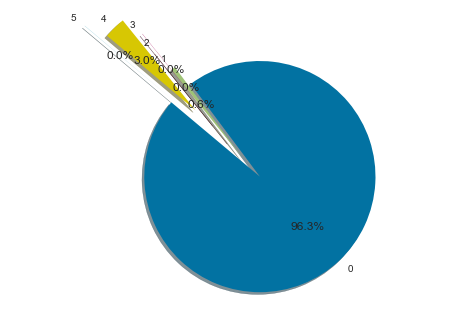

In [9]:
kmeans = KMeans(n_clusters=6)
dfEvaluation=dfInsertRow(dfEvaluation,Clustering(kmeans,X_reduced, y,"K-Means",explodeK))

**AGNES with # of clusters=5**

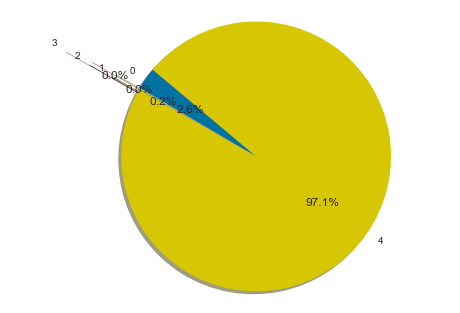

In [10]:
AGNES = AgglomerativeClustering(n_clusters=5)
dfEvaluation=dfInsertRow(dfEvaluation,Clustering(AGNES,X_reduced, y,"AGNES",explodeA))

**DBSCAN with eps=0.04, min_samples=72**

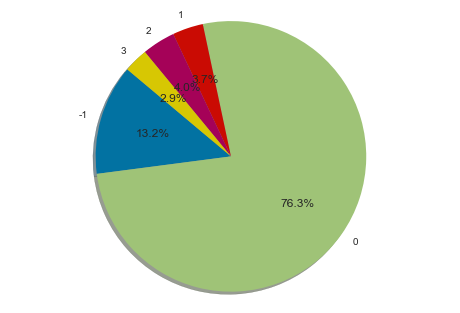

In [11]:
DB=DBSCAN(eps=0.04, min_samples=72) #for reverse take eps=0.3
dfEvaluation=dfInsertRow(dfEvaluation,Clustering(DB,X_reduced, y,"DBSCAN",explodeD))

<h3>Evaluation Table</h3>

In [12]:
pd.set_option('display.max_colwidth', None)
dfEvaluation.head(len(dfEvaluation))

,Experiment,# of Clusters,Average Number of Instances in Clusters,Std. Dev.,SSE,NMI,Silhoutte Value,Adjusted RI
0,K-Means,6,"{0: 21265, 1: 128, 2: 1, 3: 7, 4: 668, 5: 8, 'avg': 3679.5}",7867.979680,108475,0.002279,0.882208,-0.002596
1,AGNES,5,"{0: 583, 1: 35, 2: 11, 3: 1, 4: 21447, 'avg': 4415.4}",8518.641432,---,0.001055,0.910104,-0.001390
2,DBSCAN,5,"{-1: 2909, 0: 16839, 1: 811, 2: 874, 3: 644, 'avg': 4415.4}",6266.925071,---,0.004560,0.249948,0.002690
